# Things from 2024-03-13 meeting

#### start this notebook on the orion partition, 1 node, 40 tasks, use --exclusive for additional slurm parameters, and don't forget to type your dataprep conda env path


# ipynb Internal Links / Named Anchors

links to a heading are called internal links or named anchors [see the rules here](https://jupyterlab.readthedocs.io/en/stable/user/urls.html#linking-notebook-sections)

### Table of Contents Example
1) [jump to Section TITLE](#Section-TITLE)
2) [heading with an apostrophe](#Kerrie's-section)
3) [heading with a question mark](#Section-title-is-a-question?)

### Section TITLE

jupyter markdown works a little different than standard markdown, notice capitalization matters in the internal link, it must match exactly


[back to TOC](#Table-of-Contents-Example)


### Kerrie's section

special characters also work differently that standard markdown

[back to top of notebook](#Things-from-2024-03-13-meeting)

### Section title is a question?

to see what to paste in the link part () of an internal link: hover over the paragraph icon of a rendered heading

# Importing your own custom functions

1) Save your functions in a .py script. 

    Here, I've made file called custom_functions.py in the same directory as this notebook. 
    
    It contains a function called my_addition_func that adds two numbers together

2) use 'import' to import your script

3) you can access your functions with '.'

#### Here are a few different ways to do the same thing:

In [ ]:
# plain import

import custom_functions

custom_functions.my_addition_func(1,2)

In [ ]:
# rename your collection of functions on import

import custom_functions as kerrie

kerrie.my_addition_func(1,2)

In [ ]:
# import only a single function

from custom_functions import my_addition_func

my_addition_func(1,2)

In [ ]:
# import a single function and rename it on import

from custom_functions import my_addition_func as add_stuff

add_stuff(1,2)

#### if custom_functions.py was not in the same directory as this notebook

You could create a python package or you could simply tell python where to find your functions. We'll cover the second option here.

Tell python where to find your functions: The operating system has speficic places it looks for executables (like your custom functions or functions from python packages or even linux commands like ls or cd). The list of places the operating system looks is in a system variable called 'PATH'. You need to add the directory where your functions live, e.g. "append your PATH". 

I've made an identical script of custom functions at /our/shared/datasets/temporary/pyscript_custom_functions.py

The process to import functions from this script would be:

In [ ]:
import sys

In [14]:
basedir='/our/shared/datasets/dir/'

In [ ]:
# don't append the script, append the directory where the script lives
sys.path.append(basedir+'temporary/')

In [ ]:
import pyscript_custom_functions as kerrie

In [ ]:
kerrie.my_addition_func(1,2)


# Reproject bounding box

In [1]:
# packages
import xarray as xr
import rioxarray as rio

In [2]:
# paths
basedir='/our/shared/datasets/dir/'
path_to_raw_data = 'raw_data/'
path_to_climatic = basedir + path_to_raw_data + 'ERA5/month/'

path_to_pre = path_to_climatic + 'era5_monthly_means_50_21_pre.nc'
path_to_atlas_ai=basedir + path_to_raw_data + 'ATLAS-AI project/ATLAS-AI/AWI/2022_AWI_43-SSA-contiguous_AWI_43-SSA_2003.tif'

# btw, I highly recommend replacing the space with an underscore in the dir "ATLAS-AS project"
# spaces in dir and file names can cause problems in a linux operating system

In [3]:
# AWI
atlas_ai=xr.open_dataset(path_to_atlas_ai)
atlas_ai_unproj=atlas_ai.rio.reproject(4326) # reproject the whole thing
minx,miny,maxx,maxy = atlas_ai_unproj.rio.bounds() # now get the bounds
print(minx,miny,maxx,maxy)
atlas_ai_unproj

-25.41333938774126 -37.46356887029586 63.54114216184068 27.363195735869255


<xarray.Dataset>
Dimensions:      (x: 10124, y: 7378, band: 1)
Coordinates:
  * x            (x) float64 -25.41 -25.4 -25.39 -25.38 ... 63.52 63.53 63.54
  * y            (y) float64 27.36 27.35 27.34 27.33 ... -37.44 -37.45 -37.46
  * band         (band) int64 1
    spatial_ref  int64 0
Data variables:
    band_data    (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan

#### notice the longitude coordinates in atlas_ai_unproj are on the -180 to 180 scale not 0 to 360 scale

#### if we plot the original data atlas_ai and the reprojected data atlas_ai_unproject we can see the reprojection worked

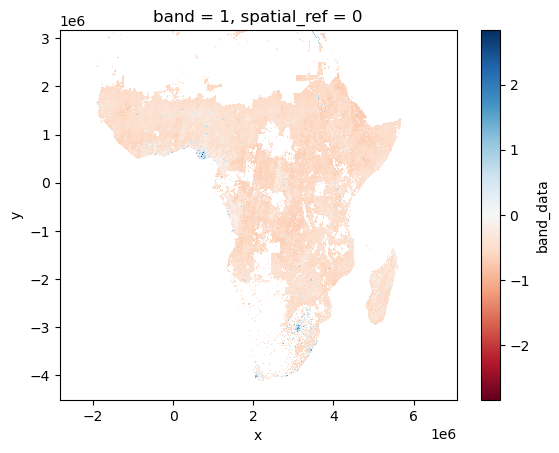

In [4]:
# plot
atlas_ai.band_data.plot(cmap='RdBu')

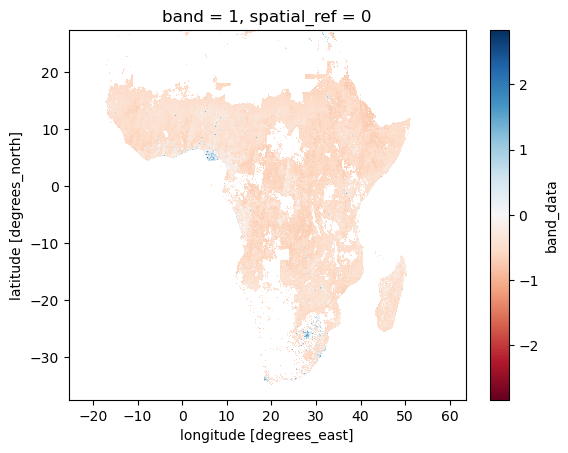

In [5]:
# plot
atlas_ai_unproj.band_data.plot(cmap='RdBu')


In [6]:
del atlas_ai, atlas_ai_unproj # free up RAM

#### it looks like part of the top of Africa is chopped off even in the original AWI data file, so the reprojection has the same extents

#### now look at precipitation

In [7]:
# let it auto chunk
pre_world = xr.open_dataarray(path_to_pre, decode_coords = "all", chunks='auto')#{'time':-1,'latitude':-1,'longitude':60})
pre_world

<xarray.DataArray 'tp' (time: 864, latitude: 1801, longitude: 3600)>
dask.array<open_dataset-tp, shape=(864, 1801, 3600), dtype=float32, chunksize=(156, 327, 655), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
  * latitude   (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time       (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
Attributes:
    units:      m
    long_name:  Total precipitation

In [8]:
# start a LocalCluster
from dask.distributed import Client,LocalCluster

nworkers=54  # I'm choosing a number that divides evenly into the number of auto chunks (216)
cluster=LocalCluster(n_workers=nworkers,threads_per_worker=1) # a cluster where each thread is a separate process or "worker"
client=Client(cluster)  # connect to your compute cluster
client.wait_for_workers(n_workers=nworkers,timeout=10) # wait up to 10s for the cluster to be fully ready, error if not ready in 10s
client # print info

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 54
Total threads: 54,Total memory: 183.59 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36436,Workers: 54
Dashboard: http://127.0.0.1:8787/status,Total threads: 54
Started: Just now,Total memory: 183.59 GiB
Comm: tcp://127.0.0.1:35352,Total threads: 1
Dashboard: http://127.0.0.1:44245/status,Memory: 3.40 GiB
Nanny: tcp://127.0.0.1:42892,


#### pre_world longitudes are 0 to 360. this is what was causing the problem clipping part of Africa incorrectly

#### to fix the problem, just re-write the longitude coordinate to -180 to 180

#### this is something that should be done for every input dataset as part of the data cleaning process anyways

In [9]:
lon_attrs=pre_world.longitude.attrs # copy metadata
pre_world.coords['longitude']=xr.where(pre_world.coords['longitude']>180,pre_world.coords['longitude']-360,pre_world.coords['longitude'])
pre_world=pre_world.roll(longitude=1799,roll_coords=True)
pre_world['longitude'].attrs=lon_attrs
pre_world.rio.write_crs(4326, inplace = True)
pre_world

<xarray.DataArray 'tp' (time: 864, latitude: 1801, longitude: 3600)>
dask.array<rechunk-merge, shape=(864, 1801, 3600), dtype=float32, chunksize=(156, 327, 655), chunktype=numpy.ndarray>
Coordinates:
  * longitude    (longitude) float32 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * latitude     (latitude) float32 90.0 89.9 89.8 89.7 ... -89.8 -89.9 -90.0
  * time         (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2021-12-01
    spatial_ref  int64 0
Attributes:
    units:      m
    long_name:  Total precipitation

In [10]:
%%time
# this will crash your notebook if you aren't running on enough cores for this ~21GB data variable
# the fewer tasks you've launched the jupyter session with, the slower this will run
pre_world=pre_world.compute()

CPU times: user 15.6 s, sys: 28 s, total: 43.5 s
Wall time: 41.3 s


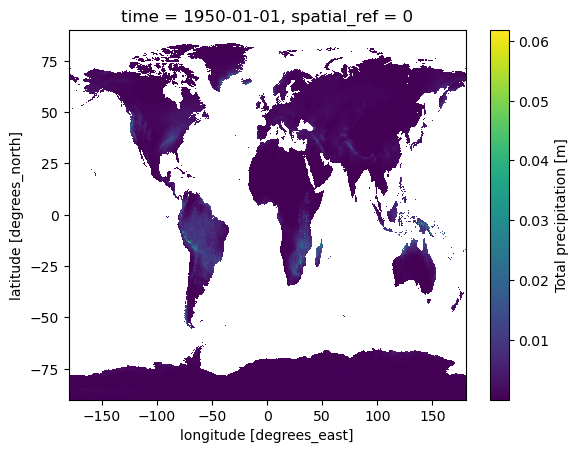

In [11]:
pre_world.isel(time=0).plot()

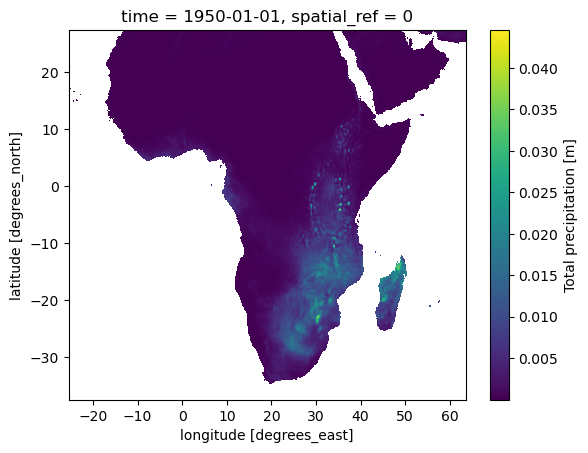

In [12]:
pre = pre_world.rio.clip_box(minx,miny,maxx,maxy)
pre.isel(time=0).plot()

#### since the atlas_ai variable doesn't include the northernmost part of Africa this clip looks like it worked correctly

### rewrite netcdf files to change dimension/coordinate names

In [ ]:
# import xarray as xr
# import dask
# from dask.distributed import Client,LocalCluster

In [ ]:
# start a LocalCluster
# we are using dask.distributed LocalCluster because I couldn't get this to work with regular dask (single-machine scheduler)

# nworkers=40  # make this the same as how many tasks you launched your jupyter session with
# cluster=LocalCluster(n_workers=nworkers,threads_per_worker=1) # a cluster where each thread is a separate process or "worker"
# client=Client(cluster)  # connect to your compute cluster
# client.wait_for_workers(n_workers=nworkers,timeout=10) # wait up to 10s for the cluster to be fully ready, error if not ready in 10s
# client # print info

In [ ]:
# something weird is going on with the ERA5 file when time gets decoded
# so first, don't decode time
# ds=xr.open_dataset(path_to_pre,chunks='auto',decode_times=False,lock=False).rename({'latitude':'lat','longitude':'lon'})
ds=xr.open_dataset(path_to_pre,chunks='auto',decode_times=False).rename({'latitude':'lat','longitude':'lon'})

# then, copy the attributes from the un-decoded time variable
# we'll use these later when we re-write the netcdf
calendar=ds.time.attrs['calendar']
units=ds.time.attrs['units']

# then, decode time with the cftime library
ds=xr.decode_cf(ds,use_cftime=True)
ds=ds.transpose('lat','lon','time')

# change precip units
ds['tp']=ds.tp*1000. # m-->mm
ds.tp.attrs['units']='mm'
ds

In [ ]:
# new file path and name
outdir=basedir+'temporary/'
prfile=outdir+'era5_monthly_means_50_21_pre.nc'

In [ ]:
%%time

# the encodings below allow you to keep the same dimension/coordinate attributes from the original file
# we are essentially overriding some xarray default settings here
time_encoding={'_FillValue':None,'calendar':calendar,'units':units} 
lat_encoding={'_FillValue':None}
lon_encoding={'_FillValue':None}

# compute and write new file in parallel
output=ds.to_netcdf(prfile,
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding},
            compute=False)
output.compute()

In [13]:
client.shutdown()

### now run climate-indices command line tool

In [ ]:
import subprocess
import matplotlib.pyplot as plt

In [ ]:
# below works for me but probably won't for others
# this is because I'm using my own installation of miniconda instead of using the Orion system module conda
# we'll probably have to go through it together and modify a few things to get it working 

# user conda information
user_home='$HOME/'
conda_init_file=user_home+'miniconda3/etc/profile.d/conda.sh'  # you need to find your conda.sh script
conda_env='/workspace/username/envs/dataprep' # path user-specific conda env

# create command enclosed in ""
# everything but the final command should end with ;
command_conda_init=". "+conda_init_file+";"               # initialize conda
command_env_activate="conda activate "+conda_env+";"      # activate conda environment 
command_echo_env="echo 'conda env =' $CONDA_DEFAULT_ENV;" # print active env name
command_spi="process_climate_indices "+\
                "--index spi "+\
                "--periodicity monthly "+\
                "--netcdf_precip "+prfile+" "\
                "--var_name_precip tp "+\
                "--output_file_base "+outdir+" "\
                "--scales 6 12 "+\
                "--calibration_start_year 1951 "+\
                "--calibration_end_year 2021 "+\
                "--multiprocessing all"

In [ ]:
# double check spaces are all good in command_spi
command_spi

In [ ]:
# string all the commands together
# climate-indices commands take a very long time, this took 30 minutes to run
# also you get a lot of divide by zero and nan runtime warning and unless 
# the climate-indices source is modified, I don't think there is any way to silence 
# these when calling from python like this

subprocess.run(command_conda_init+
               command_env_activate+
               command_echo_env+
               command_spi,
               shell=True)

In [ ]:
# take a look at the results
ds_g06=xr.open_dataset(basedir+'temporary/_spi_gamma_06.nc')
ds_g12=xr.open_dataset(basedir+'temporary/_spi_gamma_12.nc')
ds_p06=xr.open_dataset(basedir+'temporary/_spi_pearson_06.nc')
ds_p12=xr.open_dataset(basedir+'temporary/_spi_pearson_12.nc')
ds_g06

In [ ]:
# 6-month spi so first 5 time indexes will be nan
# import cartopy
fig=plt.figure(figsize=(15,10))

ax=fig.add_subplot(221)
ds_g06.spi_gamma_06.isel(time=11).plot(ax=ax)

ax=fig.add_subplot(222)
ds_g12.spi_gamma_12.isel(time=11).plot(ax=ax)


ax=fig.add_subplot(223)
ds_p06.spi_pearson_06.isel(time=11).plot(ax=ax)

ax=fig.add_subplot(224)
ds_p12.spi_pearson_12.isel(time=11).plot(ax=ax)

In [ ]:
fig=plt.figure(figsize=(15,2))
y1=ds_g06.spi_gamma_06.sel(lat=0,lon=25,method='nearest')  # gamma in blue
y2=ds_p06.spi_pearson_06.sel(lat=0,lon=25,method='nearest') # pearson in orange
y1.plot()
y2.plot()
plt.axhline(y=0,color='grey',linestyle='--')
plt.show()


fig=plt.figure(figsize=(15,2))
y1=ds_g12.spi_gamma_12.sel(lat=0,lon=25,method='nearest')  # gamma in blue
y2=ds_p12.spi_pearson_12.sel(lat=0,lon=25,method='nearest') # pearson in orange
y1.plot()
y2.plot()
plt.axhline(y=0,color='grey',linestyle='--')
plt.show()

# Things from 2024-03-20 meeting

- aggregate tif data to netcdf with time dim

In [ ]:
# fix up metadata before writing to netcdf
atlas_ai=atlas_ai.squeeze()
del atlas_ai.coords['band']
atlas_ai=atlas_ai.rename({'band_data':'AWI'})

# create time dim

# create netcdf encodings

# write netcdf

In [ ]:
xr.open_mfdataset()